In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

In [ ]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2018, 1, 1)

tickers = ['ADBE','MSFT']

df = yf.download(tickers, start, end)['Close']

[*********************100%***********************]  2 of 2 completed


1007.2


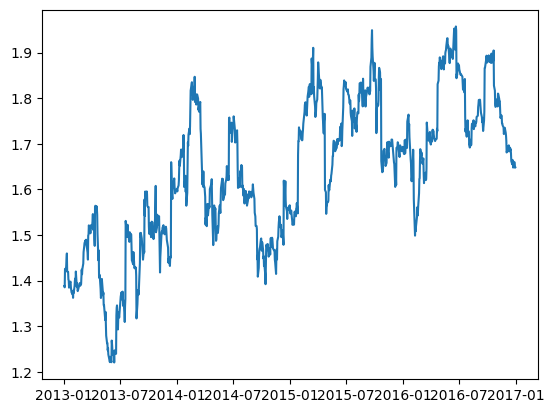

In [ ]:
ratio=df['ADBE']/df['MSFT']
train_test_ratio= len(ratio)*0.8
print(train_test_ratio)

train= ratio[:1007]
test= ratio[1007:]

plt.plot(train)
plt.show()

Implementing the Bollinger band


In [93]:
window=60
k=1
movavg=train.rolling(window=window, center= False).mean()

#calculating standard deviation (volatility)
std=train.rolling(window=20, center=False).std()

upper_band= movavg + (k*std)
lower_band= movavg - (k*std)

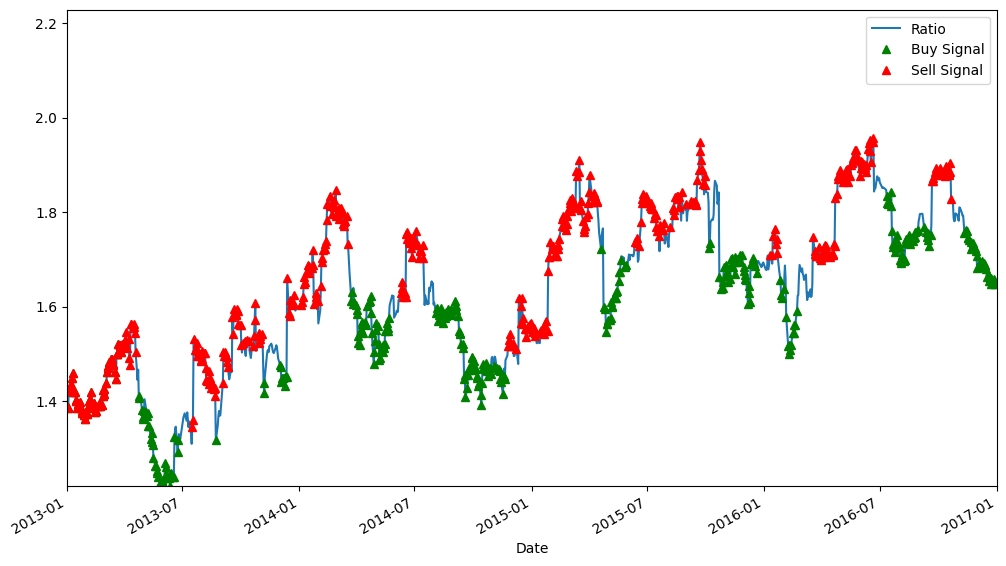

In [94]:
plt.figure(figsize=(12,7))
plt.plot(train, label='Ratio')
buy = train.copy()
sell = train.copy()
buy[train>lower_band] = 0
sell[train<upper_band] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.xlim('2013-01-01','2017-01-01')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

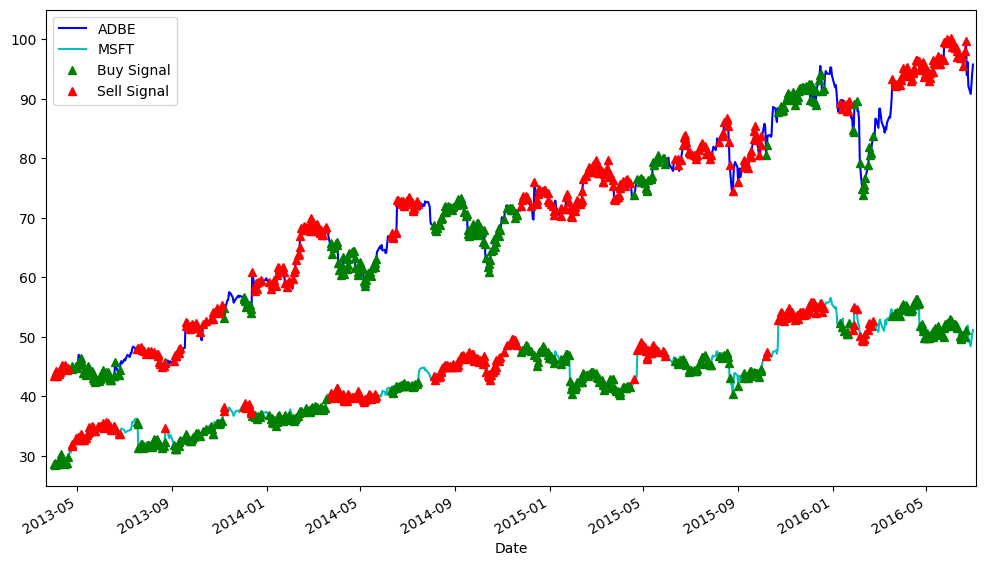

In [95]:
plt.figure(figsize=(12,7))
S1 = df['ADBE'].iloc[:881]
S2 = df['MSFT'].iloc[:881]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 105)
plt.xlim('2013-03-22', '2016-07-04')

plt.legend(['ADBE', 'MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

In [86]:
def trade(S1, S2, window, k):
    if window == 0 or window >= len(S1):
        return 0
    ratio = S1 / S2
    ma = ratio.rolling(window=window).mean()
    std = ratio.rolling(window=window).std()
    upper_band = ma + (k * std)
    lower_band = ma - (k * std)

    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratio)):
        if np.isnan(ma.iloc[i]) or np.isnan(std.iloc[i]):
            continue
        if ratio.iloc[i] > upper_band.iloc[i]:
            money -= S1.iloc[i] - S2.iloc[i] * ratio.iloc[i]
            countS1 -= 1
            countS2 += ratio.iloc[i]
        elif ratio.iloc[i] < lower_band.iloc[i]:
            money += S1.iloc[i] - S2.iloc[i] * ratio.iloc[i]
            countS1 += 1
            countS2 -= ratio.iloc[i]
        elif lower_band.iloc[i] <= ratio.iloc[i] <= upper_band.iloc[i]:
            money += S1.iloc[i] * countS1 + S2.iloc[i] * countS2
            countS1 = 0
            countS2 = 0
    return money

# Training set
length_scores = [trade(df['ADBE'].iloc[:1057], df['MSFT'].iloc[:1057], l, 1) for l in range(255)]
best_length = np.argmax(length_scores)
print('Best window length:', best_length)

# Test set
length_scores2 = [trade(df['ADBE'].iloc[1057:], df['MSFT'].iloc[1057:], l, 1) for l in range(255)]
best_length2 = np.argmax(length_scores2)
print(best_length2, 'day window:', length_scores2[best_length2])


Best window length: 236
86 day window: 270.6920085239873


In [96]:
trade(df['ADBE'].iloc[881:], df['MSFT'].iloc[881:], 236,1)


453.72470759880554